[View in Colaboratory](https://colab.research.google.com/github/suchananw/machine/blob/master/ML_Project2.ipynb)

# Import 

In [0]:
!pip install edward

%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import six
import tensorflow as tf

from edward.models import (MultivariateNormalDiag, Normal)

plt.style.use('ggplot')

# Generate Dataset

กำหนด Pi, Mu, Sigma เริ่มต้นเพื่อใช้สุ่มชุดข้อมูล 5 กลุ่มด้วยฟังก์ชัน numpy.random.multivariate_normal
จะได้ชุดข้อมูลที่มีกระจายตัวเป็นกลุ่ม จำนวน 5 กลุ่มตามที่โจทย์กำหนด



In [0]:
def build_dataset(N):
  pi = np.array([0.1, 0.3, 0.1, 0.3, 0.2])
  # mean
  mus = [[1, 1], [-3, -1], [-2, 3], [1, -2], [3, 2]]    
  # variance
  stds = [[0.15, 0.15], [0.15, 0.15], [0.15, 0.15], [0.15, 0.15], [0.15, 0.15]]
  
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

  return x , mus


N = 500  # number of data points
K = 5  # number of components
D = 2  # dimensionality of data
# ed.set_seed(42)

x_train , mus = build_dataset(N)
sess = ed.get_session()


# Trans x_train into list form
x_data = []
for x in x_train:
  x_data.append([[x[0],x[1]]])

# Plot dataset

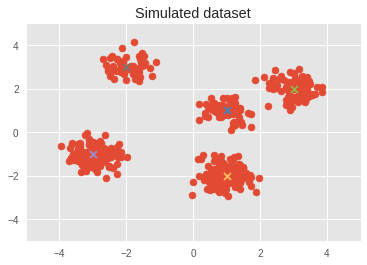

In [12]:
plt.scatter(x_train[:, 0], x_train[:, 1]),
for i in mus:
  plt.scatter(i[0],i[1],marker='x')
plt.axis([-5, 5, -5, 5])
plt.title("Simulated dataset")
plt.show()

In [0]:
def evalLogLikeli():
  logL = 0
  for i in range(N):
    logL += np.log(sum(pi*normalX))
  
  return sum(logL)

In [0]:
def genModel():
  # Generate Model
  model = MultivariateNormalDiag(loc = mu, scale_diag = sigmasq)

  # Get prob of each x(n) from model
  normalX = model.prob(x_data).eval()

  return  (model , normalX)

# Model

*   สร้างโมเดลเริ่มต้นขึ้นมาโดยสุ่มค่า Pi, Mu, Sigma ให้โมเดล (ซึ่งโมเดลจะถูกปรับให้เข้ากับข้อมูลในภายหลัง)
*   ค่า Pi อยู่ในรูป array 5x1 มิติ บอกค่าความน่าจะเป็นที่จะมีข้อมูลอยู่ในกลุ่ม 5 กลุ่มนั้น มีค่ารวม=1
*   ค่า Mu อยู่ในรูป array 5x2 มิติ บอกค่าเฉลี่ยของข้อมูล สัมพันธ์กับมิติของข้อมูล (ในที่นี้คือ 2 มิติ)
*   ค่า Sigma อยู่ในรูป array 5x2 มิติ บอกขอบเขตของข้อมูลแต่ละกลุ่ม 
*   หาค่า Log Likelihood จากโมเดลที่เราสร้าง



In [101]:
# Define the prior on pi ∈[0,1]
pi = [0.2,0.2,0.2,0.2,0.2]    
# Define the prior on each component μk∈RD 
mu = [[-3.,3.], [-3.,-3.], [2.,-2.], [0.,1.], [4.,3.]]
# Define the prior on each component variancek∈RD
sigmasq =  [[0.3, 0.3], [0.3, 0.3], [0.3, 0.3], [0.3, 0.3], [0.3, 0.3]]

[model , normalX] = genModel() 

logLike = evalLogLikeli()
print (logLike)

-3964.956366185098


# E Step

*   คำนวณหาความน่าจะเป็นที่จุดใดๆจะอยู่ในกลุ่มของข้อมูลทั้ง5กลุ่ม (Gamma) ตามสูตร
*   ค่าความน่าจะเป็นที่ได้ของจุดใดๆ จะมีทั้งหมด 5 ค่าตามจำนวนกลุ่มข้อมูล และผลรวมมีค่า=1

In [0]:
def Estep():
  def calPriorLike(normalxN):
    gammaN = (pi*normalxN)/np.sum(pi*normalxN)
    return gammaN

  # Calculate Gamma 
  gamma = []
  for i in range(N):
    gN = calPriorLike(normalX[i])
    gamma.append([gN[0],gN[1],gN[2],gN[3],gN[4]])
    
  # Collect cluster
  clusters = []
  for i in range(N):
    clusters.append(np.argmax(gamma[i]))

  plotMean()
  return gamma , clusters

In [0]:
def plotMean():
  plt.scatter(x_train[:, 0], x_train[:, 1]),
  for i in mu:
    plt.scatter(i[0],i[1],marker='x')
  plt.axis([-5, 5, -5, 5])
  plt.title("Simulated dataset with Mean")
  plt.show()

# M Step

*   คำนวณค่า Pi , Mu , Sigma ใหม่โดยใช้ค่า Gamma ที่ได้จากขั้นตอน E-step โดยที่
*   คำนวณความน่าจะเป็นรวมของจุดทั้งหมดที่ถูกจัดให้อยู่กลุ่มใดๆ จะได้ 5 ค่า ตามจำนวนกลุ่ม แทนด้วย Nk
*   ค่า Pi , Mu , Sigma ได้มาจากการคำนวนตามสูตร

In [0]:
def Mstep(gamma):
  # Calculate Nk
  Nk = []
  for i in range(K) :
    Ni = 0
    for j in range(N):
      Ni += gamma[j][i]
    Nk.append(Ni)
    
  # Calculate new mu
  muNew = []
  for i in range(K) :
    muI = 0
    for j in range(N):
      muI += np.array(gamma[j][i])*x_train[j].astype(np.float32)
    muNew.append((muI/Nk[i]).tolist())
    
    
  # Calculate new sigma
  sigmaNew = []
  for i in range(K) :
    sigI = 0
    for j in range(N):
      sigI += np.array(gamma[j][i])*(x_train[j]-muNew[i])*np.transpose(x_train[j]-muNew[i]).astype(np.float32)
    sigmaNew.append((sigI/Nk[i]).tolist())
    
  # Calculate new pi
  piNew = np.array(Nk)/N
  
  return (muNew , sigmaNew , piNew)

# Criticism

*   ทำ E-step และ M-step ตามลำดับ
*   นำค่า Pi , Mu , Sigma ใหม่ที่ได้ไปคำนวนหา Log Likelihood ใหม่
*   ถ้า Log Likelihood ใหม่ มีค่าต่างจากเดิมน้อยมาก แสดงว่าโมเดลเข้าสู่สมดุลแล้ว การปรับโมเดลอีกไม่ได้ทำให้ได้ผลลัพธ์ที่ีดีขึ้น
*   ถ้า Log Likelihood ใหม่ มีค่าต่างจากเดิมมาก แสดงว่ายังสามารถปรับโมเดลได้อีก นำค่า Pi , Mu , Sigma ใหม่ที่ได้ ไปกำหนดให้โมเดล แล้วทำซ้ำขั้น E-step และ M-step

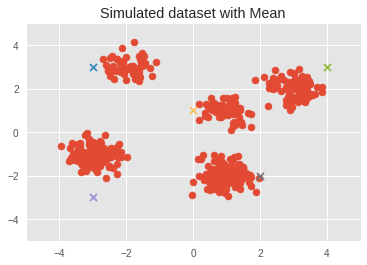

-4128.397180842881


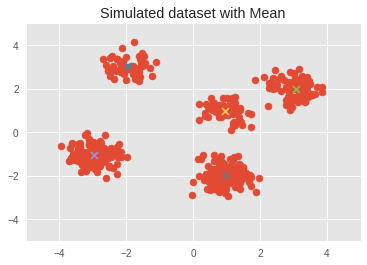

7168.4982115558105


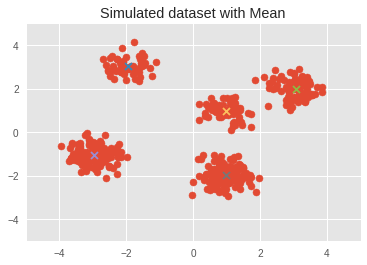

7220.973943890152


In [102]:
for i in range(10):
  gamma , clusters = Estep()

  [muNew , sigmaNew, piNew] = Mstep(gamma)

  pi = piNew
  mu = muNew
  sigmasq = sigmaNew

  logLikeNew = evalLogLikeli()
  print (logLikeNew)
  
  if abs(logLikeNew - logLike) < 100 or np.isnan(mu[0][0]):
    break
  else :
    logLike = logLikeNew

  [model , normalX] = genModel()

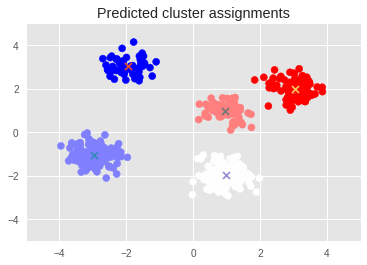

In [103]:
# Plot data colored membership

plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
for i in mu:
  plt.scatter(i[0],i[1],marker='x')
plt.axis([-5, 5, -5, 5])
plt.title("Predicted cluster assignments")
plt.show()

# Conclusion

*   การใช้ EM จัดกลุ่มของข้อมูล ทำให้ได้ความน่าจะเป็นที่ข้อมูลจะอยู่ในกลุ่มใดๆ
*   หากกำหนดโมเดลเริ่มต้นได้ไม่ดี การจัดกลุ่มข้อมูลจะไม่ได้ผลลัพธ์ที่ดี เช่น อาจจะมีกลุ่มที่ไม่มีข้อมูลใดๆอยู่เลย 

